this script plot the funding pattern of global science

In [1]:
import pandas as pd
import numpy as np
from itertools import product
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib import gridspec
from matplotlib.patches import Patch

In [32]:
pubs_path="../../data/nf_folder/Data/DerivedData/CleanedRawData/pub.pkl"

In [33]:
global_funding_path='../../data/nf_folder/Figs/global_funding.pdf'

In [4]:
pubs_df = pd.read_pickle(pubs_path)
pubs_df.head()

,id,year,dis,type,author,funder,author_distinct,funder_distinct,funded,IntCol
0,60694041,2017,9,1,"[Canada, United States]","[United States, United States]","[United States, Canada]",[United States],1,1
1,48573156,2012,89,1,[France],Not-Funded,[France],Not-Funded,0,0
2,55323671,2015,89,1,"[France, Chile]","[Chile, Chile, Chile, Chile, Chile]","[Chile, France]",[Chile],1,1
3,57633115,2016,31,1,"[Switzerland, United States]",[Switzerland],"[Switzerland, United States]",[Switzerland],1,1
4,64831413,2018,99,1,[China],"[China, China, China, China, China, China]",[China],[China],1,0


## calculate the funding ratio over year

In [6]:
def ftype(funded,cofund):
    label="null"
    if funded==0:
        label='Not-Funded'
    elif funded==1 and cofund==0:
        label='single'
    elif funded==1 and cofund==1:
        label='Cofund'
    return label
pubs_df['ftype']=pubs_df[['funded','cofund']].apply(lambda x:ftype(x.funded,x.cofund),axis=1)

In [7]:
fdtype = pubs_df.groupby(['year','ftype']).size().reset_index(name='count')
fdtype = fdtype.pivot(index='year',columns='ftype',values='count')
fdtype = fdtype.div(fdtype.sum(axis=1), axis=0)
fdtype = fdtype.reset_index().melt(id_vars='year',var_name='type', value_name='value')
fdtype.head()

,year,type,value
0,2009,Cofund,0.077263
1,2010,Cofund,0.099982
2,2011,Cofund,0.110767
3,2012,Cofund,0.111941
4,2013,Cofund,0.111349


In [8]:
#calculate the proportion of publications that are funded
funded=fdtype[fdtype.type=='Not-Funded']
funded['value']=1-funded['value']
funded['type']='Funded'
fdtype = pd.concat([fdtype,funded])

<ipython-input-8-3f2010b0510e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  funded['value']=1-funded['value']
<ipython-input-8-3f2010b0510e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  funded['type']='Funded'


In [14]:
colldata = pubs_df[pubs_df.IntCol==1]
colldata = colldata.groupby(['year','ftype']).size().reset_index(name='fdcnt')
colldata = colldata.pivot(index='year',columns='ftype',values='fdcnt')
colldata = colldata.div(colldata.sum(axis=1), axis=0)
colldata = colldata.reset_index().melt(id_vars='year',var_name='type', value_name='value')
funded_coll=colldata[colldata.type=='Not-Funded']
funded_coll['value']=1-funded_coll['value']
funded_coll['type']='Funded'
colldata=pd.concat([colldata,funded_coll])
colldata.head()

<ipython-input-14-381729645cf4>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  funded_coll['value']=1-funded_coll['value']
<ipython-input-14-381729645cf4>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  funded_coll['type']='Funded'


,year,type,value
0,2009,Cofund,0.233071
1,2010,Cofund,0.290632
2,2011,Cofund,0.314999
3,2012,Cofund,0.313685
4,2013,Cofund,0.306588


In [23]:
collcnt=pubs_df.groupby(['year','IntCol']).size().reset_index(name='collcnt')
collcnt=collcnt.replace(to_replace={'IntCol':{0:'dome',1:'intcol'}})
collcnt = collcnt.pivot(index='year',columns='IntCol',values='collcnt')
collcnt = collcnt.div(collcnt.sum(axis=1), axis=0)
collcnt = collcnt.reset_index().melt(id_vars='year',var_name='type', value_name='value')
collcnt.head()

,year,type,value
0,2009,dome,0.788537
1,2010,dome,0.780102
2,2011,dome,0.774328
3,2012,dome,0.769507
4,2013,dome,0.761927


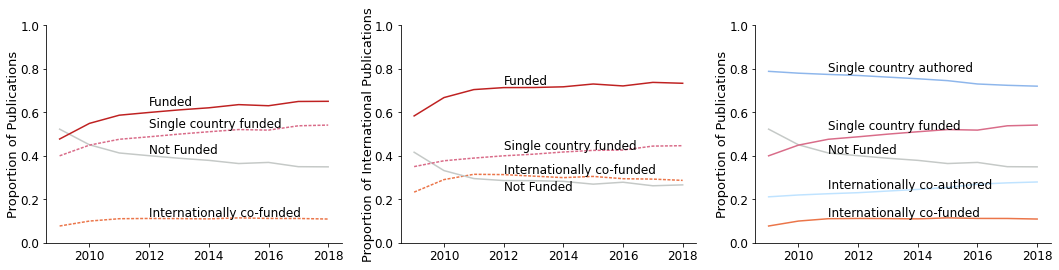

In [31]:
fig, ax=plt.subplots(nrows=1,ncols=3,figsize=(18,4))
ax0=ax[0]
ax1=ax[1]
ax2=ax[2]
sns.lineplot(x='year',y='value',hue='type',
             palette={'Cofund':'#EB7549','single':'#D96C89','Not-Funded':'#C5C9C7','Funded':'#BF2121'},
             data=fdtype,legend=False,style='type',dashes={'Cofund':(2,1),'single':(2,1),'Not-Funded':'','Funded':''},
             ax=ax0)

ax0.set_xticks(np.arange(2010,2019,2))
ax0.set_xlabel("")
ax0.spines['right'].set_visible(False)
ax0.spines['top'].set_visible(False)
ax0.set_ylabel("Proportion of Publications",fontsize=13,labelpad=0)
ax0.text(2012,0.53,s="Single country funded",fontsize=12)
ax0.text(2012,0.41,s="Not Funded",fontsize=12)
ax0.text(2012,0.12,s="Internationally co-funded",fontsize=12)
ax0.text(2012,0.63,s="Funded",fontsize=12)
ax0.tick_params(axis='both', which='major', labelsize=12)
ax0.set_ylim(0,1)
#ax0.set_yticks(np.arange(0,9,1)/10)

sns.lineplot(x='year',y='value',hue='type',
             palette={'Cofund':'#EB7549','single':'#D96C89','Not-Funded':'#C5C9C7','Funded':'#BF2121'},
             data=colldata,legend=False,style='type',dashes={'Cofund':(2,1),'single':(2,1),'Not-Funded':'','Funded':''},
             ax=ax1)
ax1.set_xticks(np.arange(2010,2019,2))
ax1.set_xlabel("")
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_ylabel("Proportion of International Publications",fontsize=13,labelpad=0)
ax1.text(2012,0.73,s="Funded",fontsize=12)
ax1.text(2012,0.43,s="Single country funded",fontsize=12)
ax1.text(2012,0.24,s="Not Funded",fontsize=12)
ax1.text(2012,0.32,s="Internationally co-funded",fontsize=12)
ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.set_ylim(0,1)
#ax1.set_yticks(np.arange(0,5,1)/10)

sns.lineplot(x='year',y='value',hue='type',
             palette={'dome':'#1E6FD9','intcol':'#81C8FF'},
             data=collcnt,legend=False,alpha=0.5,ax=ax2)
sns.lineplot(x='year',y='value',hue='type',
             palette={'Cofund':'#EB7549','single':'#D96C89','Not-Funded':'#C5C9C7'},
             data=fdtype[fdtype.type!='Funded'],legend=False,ax=ax2)
ax2.set_xticks(np.arange(2010,2019,2))
ax2.set_xlabel("")
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.set_ylabel("Proportion of Publications",fontsize=13,labelpad=0)
ax2.text(2011,0.52,s="Single country funded",fontsize=12)
ax2.text(2011,0.41,s="Not Funded",fontsize=12)
ax2.text(2011,0.12,s="Internationally co-funded",fontsize=12)
ax2.text(2011,0.79,s="Single country authored",fontsize=12)
ax2.text(2011,0.25,s="Internationally co-authored",fontsize=12)
ax2.tick_params(axis='both', which='major', labelsize=12)
ax2.set_ylim(0,1)
#ax2.set_yticks(np.arange(0,9,1)/10)
plt.savefig(global_funding_path,bbox_inches='tight')